
# Representative Days for EPM Model

This notebook is used to calculate representative days used in the EPM model. The script is divided into 4 parts:
1. Group data by season
2. Format it for the Poncelet algorithm.
2. Calculate representative year among historical data.
2. Calculate **special and representative days** within this year.
4. Export pHours, pVREgen in EPM format.

It is based on previously developed GAMS code for the Poncelet algorithm. The objective has been to automate the process and make it more user-friendly.
The code will automatically get the min production for PV, the min production for Wind, and the max load days for each season, called the special days.
It will automatically removes the special days from the input file for the Poncelet algorithm and then runs the Poncelet algorithm to generate the representative days.

## Special days methodology

**Clustering-Based Method**
To increase the influence of extreme days on the model, we proceed as follows:
- Clustering: All days are grouped into k clusters using K-Means, and based on the features (VRE production and load).
- Selection of Extremes: Days with the **lowest PV**, **lowest Wind**, and **highest load** are identified as special days. For multi-zone cases, total daily PV or wind production across all zones is used.
- Cluster Exclusion and Weight:
    - The entire cluster containing each extreme day is excluded from the main dataset.
    - The centroid (i.e., most representative day) of each excluded cluster is then included as a special day.
    - This day is assigned a weight equal to the cluster’s share of the original dataset.

This method ensures that days with system stress (e.g., low renewable production) are adequately represented in the model, while also maintaining a balance with the overall dataset.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from utils_reprdays import *

## 0. User input parameters (to manually change)

- 1. `seasons_dict`: This dictionary defines the mapping of months to seasons. The keys are month numbers (1-12), and the values are season numbers (1-4). Fore example seasons ca, be defined as follows:
  - Season 1: May, June, July, August, September
  - Season 2: January, February, March, April, October, November, December
- 2. `filenames_input`: This dictionary contains the filenames of the input data files. The keys are technology types (e.g., 'PV', 'Wind', 'Load'), and the values are the corresponding filenames path from the `input` folder. The files should be placed in the `input` folder. **Users are responsible for ensuring that the data is formatted correctly.** Reference examples are available in the data_test folder. The required columns are `zone`, `month` (or `season`), `day`, `hour`.

In [4]:
# The definition of seasons is based on the month number.
seasons_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 4,
    11: 4,
    12: 4
}

# The name of the file that must be in the input folder
filenames_input = {'PV': 'irena/data_sapp_solar.csv',
                   'Wind': 'irena/data_sapp_wind.csv',
                   # 'Load': 'load_full_year.csv'
                   }

#
zones_to_remove = []


## 1. Create the folder structure

In [3]:
folder_input = 'input'
# Make folder
if not os.path.exists(folder_input):
    os.makedirs(folder_input)
    print(f'Input folder: {folder_input}')

folder_output = 'output'
# Make folder
if not os.path.exists(folder_output):
    os.makedirs(folder_output)
    print(f'Output folder: {folder_output}')

Input folder: input
Output folder: output


## 2. Process data to group by season
Renewable ninja ata is processed to group months into season, to be used as input to EPM. This step may be skipped if one wishes to keep the seasonal definition at the monthly scale, or updated based on the seasonal grouping that makes the most sense for the case study at hand.

In [6]:
def month_to_season(data, seasons_dict, other_columns=None):
    """Convert month number to season number."""
    data = data.rename(columns={'season': 'month'})
    data['season'] = data.apply(lambda row: seasons_dict[row['month']], axis=1)
    data = data.sort_values(by=['season', 'month', 'day', 'hour'])
    data = data[~((data['month'] == 2) & (data['day'] == 29))]
    # Renumber days sequentially within each season
    data['season_day'] = data.groupby(other_columns + ['season']).cumcount() // 24 + 1
    data = data.drop(columns=['day']).rename(columns={'season_day': 'day'})
    data = data.set_index(other_columns + ['season', 'day', 'hour']).reset_index().drop(columns=['month'])
    data = data.sort_values(by=other_columns + ['season', 'day', 'hour'])
    return data

filenames = {key: os.path.join(folder_input, filename) for key, filename in filenames_input.items()}

display('WARNING: Ensure that the zones in the data are consistent across all input files.')

# Process each file and save the results
for key, filename in filenames.items():
    print(f'Processing {key} data from {filename}')
    if not os.path.exists(filename):
        raise FileNotFoundError(f'File {os.path.abspath(filename)} not found. Please check the input folder.')
    # Load the data
    data = pd.read_csv(filename, index_col=False)

    # Check if the required columns are present
    required_columns = ['zone', 'month', 'day', 'hour']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f'Missing required columns in {filename}. Required columns missing: {", ".join([col for col in required_columns if col not in data.columns])}')

    # Display zones in the data
    display(f'Number of zones in {key}: {data["zone"].nunique()}')
    display(f'Zones in {key}: {data["zone"].unique()}')

    # Load data hours should start with 0, not 1
    if data['hour'].min() == 1:
        data['hour'] = data['hour'] - 1

    # Rename value by 2018
    data = data.rename(columns={'value': 2018})

    # Remove zones that are not needed
    data = data[~data['zone'].isin(zones_to_remove)]

    # Convert month to season
    data = month_to_season(data, seasons_dict, other_columns=['zone'])

    # Save the data
    name, ext = os.path.splitext(filename)
    filename = f'{name}_season{ext}'

    data.to_csv(filename, float_format='%.4f', index=False)
    print(f'Data saved to {filename}')

'WARNING: Ensure that the zones in the data are consistent across all input files.'

Processing PV data from input/irena/data_sapp_solar.csv


'Number of zones in PV: 12'

"Zones in PV: ['Angola' 'Botswana' 'DemocraticRepublicoftheCongo' 'Eswatini' 'Lesotho'\n 'Malawi' 'Mozambique' 'Namibia' 'SouthAfrica' 'Zambia' 'Zimbabwe'\n 'UnitedRepublicofTanzania']"

Data saved to input/irena/data_sapp_solar_season.csv
Processing Wind data from input/irena/data_sapp_wind.csv


'Number of zones in Wind: 12'

"Zones in Wind: ['Angola' 'Botswana' 'DemocraticRepublicoftheCongo' 'Eswatini' 'Lesotho'\n 'Malawi' 'Mozambique' 'Namibia' 'SouthAfrica' 'Zambia' 'Zimbabwe'\n 'UnitedRepublicofTanzania']"

Data saved to input/irena/data_sapp_wind_season.csv


## 3. Format data for the Poncelet algorithm

In [7]:
filenames = {}
for tech, filename in filenames_input.items():
    name, ext = os.path.splitext(filename)
    filename = f'{name}_season{ext}'
    filename = os.path.join(folder_input, filename)

    if not os.path.exists(filename):
        print(f'File {filename} does not exist. Please check the input folder.')
        raise FileNotFoundError(f'File {filename} not found.')

    filenames.update({tech: filename})

# The name of the data, used to save the results
df_energy = format_data_energy(filenames)

# Drop columns with all NaN values
df_energy = df_energy.dropna(axis=1, how='all')

# Display df_energy
display(df_energy.head())
if len(df_energy) != 8760:
    print('Warning: The data does not contain a full year of data. Please check the input files.')
else:
    print('The data contains a full year of data.')

Representative year 2018


'Annual capacity factor (%):'

tech                          zone        PV      Wind
0                           Angola  0.224599  0.397303
1                         Botswana  0.220972  0.480486
2     DemocraticRepublicoftheCongo  0.193951  0.439868
3                         Eswatini  0.186509  0.408121
4                          Lesotho  0.213509  0.482277
5                           Malawi  0.213380  0.506494
6                       Mozambique  0.200211  0.399935
7                          Namibia  0.234162  0.481111
8                      SouthAfrica  0.226643  0.518788
9         UnitedRepublicofTanzania  0.225305  0.536216
10                          Zambia  0.215917  0.448374
11                        Zimbabwe  0.216868  0.460054

season  day  hour  PV_Angola  PV_Botswana  PV_DemocraticRepublicoftheCongo  \
0       1    1     0        0.0       0.0000                           0.0000   
1       1    1     1        0.0       0.0000                           0.0000   
2       1    1     2        0.0       0.0000                           0.0000   
3       1    1     3        0.0       0.0000                           0.0007   
4       1    1     4        0.0       0.0008                           0.0105   

   PV_Eswatini  PV_Lesotho  PV_Malawi  PV_Mozambique  ...  \
0       0.0000      0.0000     0.0000         0.0000  ...   
1       0.0000      0.0000     0.0000         0.0000  ...   
2       0.0000      0.0000     0.0000         0.0000  ...   
3       0.0000      0.0000     0.0000         0.0000  ...   
4       0.0129      0.0123     0.0262         0.0286  ...   

   Wind_DemocraticRepublicoftheCongo  Wind_Eswatini  Wind_Lesotho  \
0                             0.5117         0.0825        0.1282   
1                             0.4883         0.1614        0.3728   
2                             0.5385         0.2107        0.6929   
3                             0.5910         0.2655        0.7191   
4                             0.6086         0.3515        0.5589   

   Wind_Malawi  Wind_Mozambique  Wind_Namibia  Wind_SouthAfrica  \
0       0.0790           0.1744        0.5875            0.6785   
1       0.0935           0.1723        0.5413            0.7939   
2       0.1083           0.1433        0.4996            0.8632   
3       0.1196           0.1154        0.4765            0.8922   
4       0.1273           0.0964        0.4673            0.8735   

   Wind_UnitedRepublicofTanzania  Wind_Zambia  Wind_Zimbabwe  
0                         0.0975       0.1232         0.3582  
1                         0.0999       0.1210         0.3519  
2                         0.1098       0.1272         0.3411  
3                         0.1249       0.1490         0.3256  
4                         0.1473       0.1947         0.3255  

[5 rows x 27 columns]

The data contains a full year of data.


## 4. Generate representative days

**User-defined parameters**

User needs to change the following parameters in the following cell:

1. `nbr_days`: Defines the number of representative days used in the Poncelet algorithm.
2. `n_clusters`: Specifies the number of clusters (i.e., representative days) to generate, which will then be used to extract special days representing extreme clusters. More clusters lead to more extreme conditions being captured, but also increase computational complexity.
4. `nbr_bins` file: A higher number of zones or time series increases numerical complexity. Start with `nbr_bins=10` (fewer bins) for easier computation. Increase the number of bins progressively if the problem remains easy to solve.
5. `n_features_selection` (optional): Enables **automatic feature selection** to reduce the number of time series used in the Poncelet algorithm.
   This is useful when:
   - Modeling many zones or countries.
   - The number of pairwise correlations becomes large, increasing computational time.

    Use this parameter if the Poncelet algorithm takes more than a few minutes to run.

In [8]:
# Defines the number of representative days used in the Poncelet algorithm.
n_rep_days = 2

# Clustering the data to extract clusters corresponding to extreme conditions
n_clusters = 20

nbr_bins = 10

# Feature selection is optional but recommended if you are working with a large number of zones or time series. This reduces the number of pairwise correlations and helps avoid high computational complexity in the optimization step.
n_features_selection = 30

In [10]:

df_energy_cluster, df_closest_days, centroids_df = cluster_data_new(df_energy, n_clusters=n_clusters)

# Extracting special days as centroids of the extreme clusters
special_days, df_energy_no_special = get_special_days_clustering(df_closest_days,
                                                                 df_energy_cluster, threshold=0.1)

print('Number of hours in the year:', len(df_energy_no_special))
print('Removed days:', (len(df_energy) - len(df_energy_no_special)) / 24)

# Format the data (including correlation calculation) and save it in a .csv file
_, path_data_file = format_optim_repr_days(df_energy_no_special, folder_output)


selected_series, df, path_data_file_selection = (
    select_representative_series_hierarchical(path_data_file, n=n_features_selection, method='ward', metric='euclidean', scale=True, scale_method='standard'))

# Launch the optimization to find the representative days
path_data = path_data_file  # you want to include all the features to identify representative days
path_data = path_data_file_selection  # you only want to work with the reduced number of features to identify representative days

launch_optim_repr_days(path_data, folder_output, nbr_days=n_rep_days,
                       main_file='OptimizationModelZone.gms',
                       nbr_bins=nbr_bins)

# Get the results
repr_days = parse_repr_days(folder_output, special_days)

# Format the data to be used in EPM
format_epm_phours(repr_days, folder_output)
format_epm_pvreprofile(df_energy, repr_days, folder_output)
# only activate when load data is provided
# format_epm_demandprofile(df_energy, repr_days, folder_output)

# Export in .csv format
repr_days.to_csv(os.path.join(folder_output, 'repr_days.csv'), index=False)
df_energy.to_csv(os.path.join(folder_output, 'df_energy.csv'), index=False)

Number of hours in the year: 8064
Removed days: 29.0
File saved at: output/data_formatted_optim.csv
File saved at /Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/EPM/pre-analysis/representative_days/output/data_formatted_optim_selection.csv
File saved to: gams/bins_settings_10.csv
Launch GAMS code
End GAMS code
Number of days: 16
Total weight: 365
season
Q1    90.0
Q2    91.0
Q3    92.0
Q4    92.0
Name: weight, dtype: float64
pHours file saved at: output/pHours.csv
Number of hours: 365
VRE Profile file saved at: output/pVREProfile.csv


/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/EPM/pre-analysis/representative_days/utils_reprdays.py:728: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pVREProfile = pVREProfile.stack(level=['fuel', 'zone'])


## 5. Plot results

Optional cell to plot the results. It will plot the load, wind and solar data for the representative year.

In [11]:
# Get data 
input_file = pd.read_csv(os.path.join(folder_output, 'data_formatted_optim.csv'), index_col=[0,1,2])
input_file.index.names = ['season', 'day', 'hour']

VREProfile = pd.read_csv(os.path.join(folder_output, 'pVREProfile.csv'), index_col=[0,1,2,3])

pHours = pd.read_csv(os.path.join(folder_output, 'pHours.csv'), index_col=[0,1])

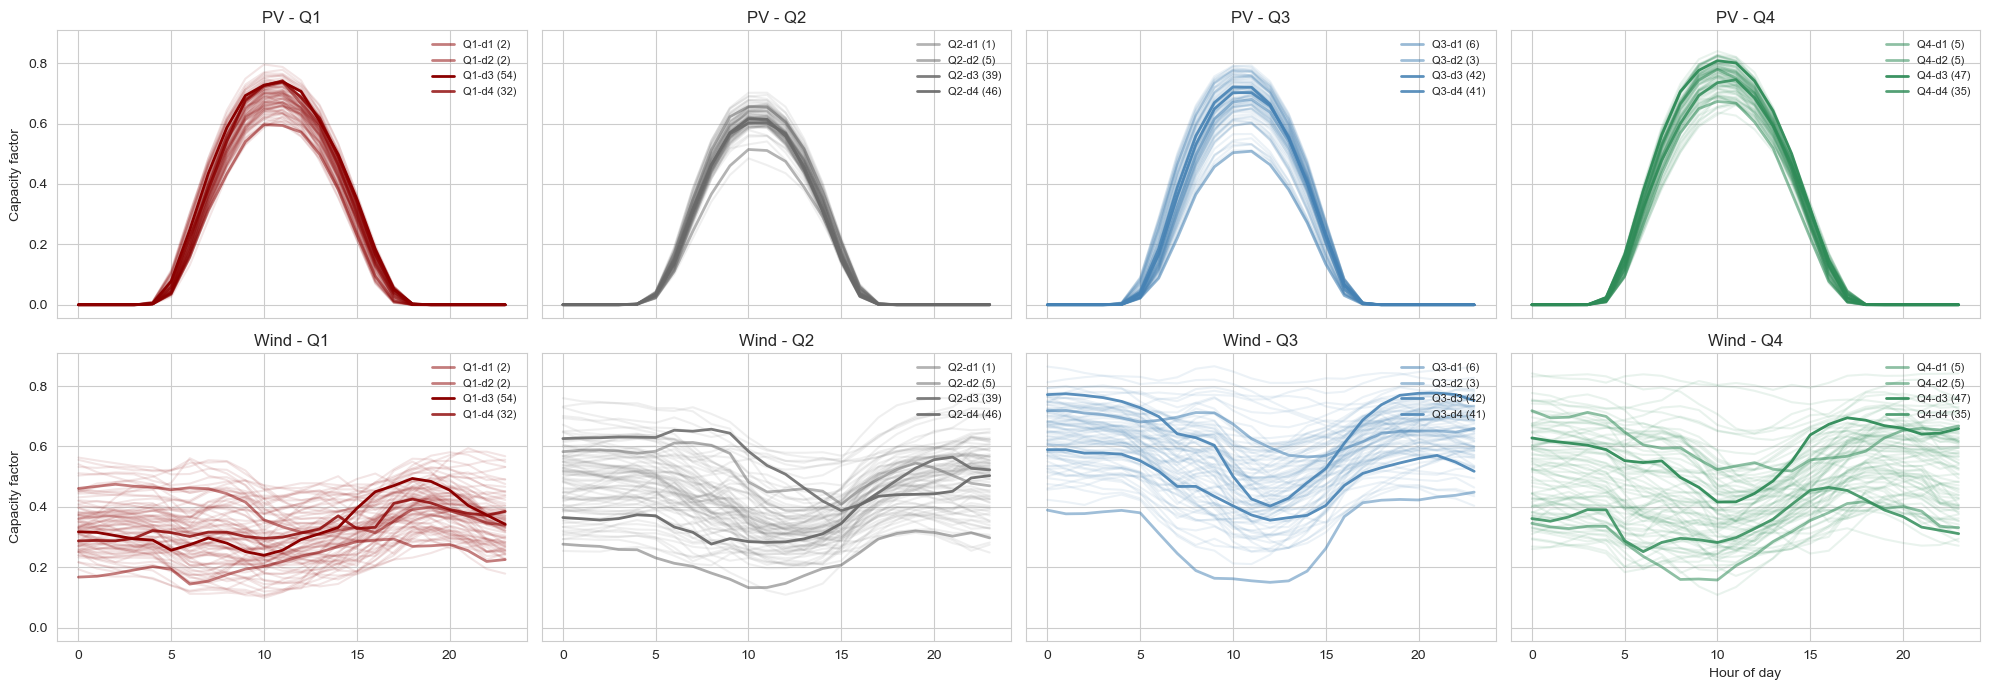

In [13]:
# Checking the representative days

# === SETTINGS ===

season_colors = {
    'Q1': 'darkred',
    'Q2': 'dimgrey',
    'Q3': 'steelblue',
    'Q4': 'seagreen'}


# Total renewable production over all zones
plot_vre_repdays(input_file=input_file, vre_profile=VREProfile, pHours=pHours,
          season_colors=season_colors, min_alpha=0.5, max_alpha=1, path=None)

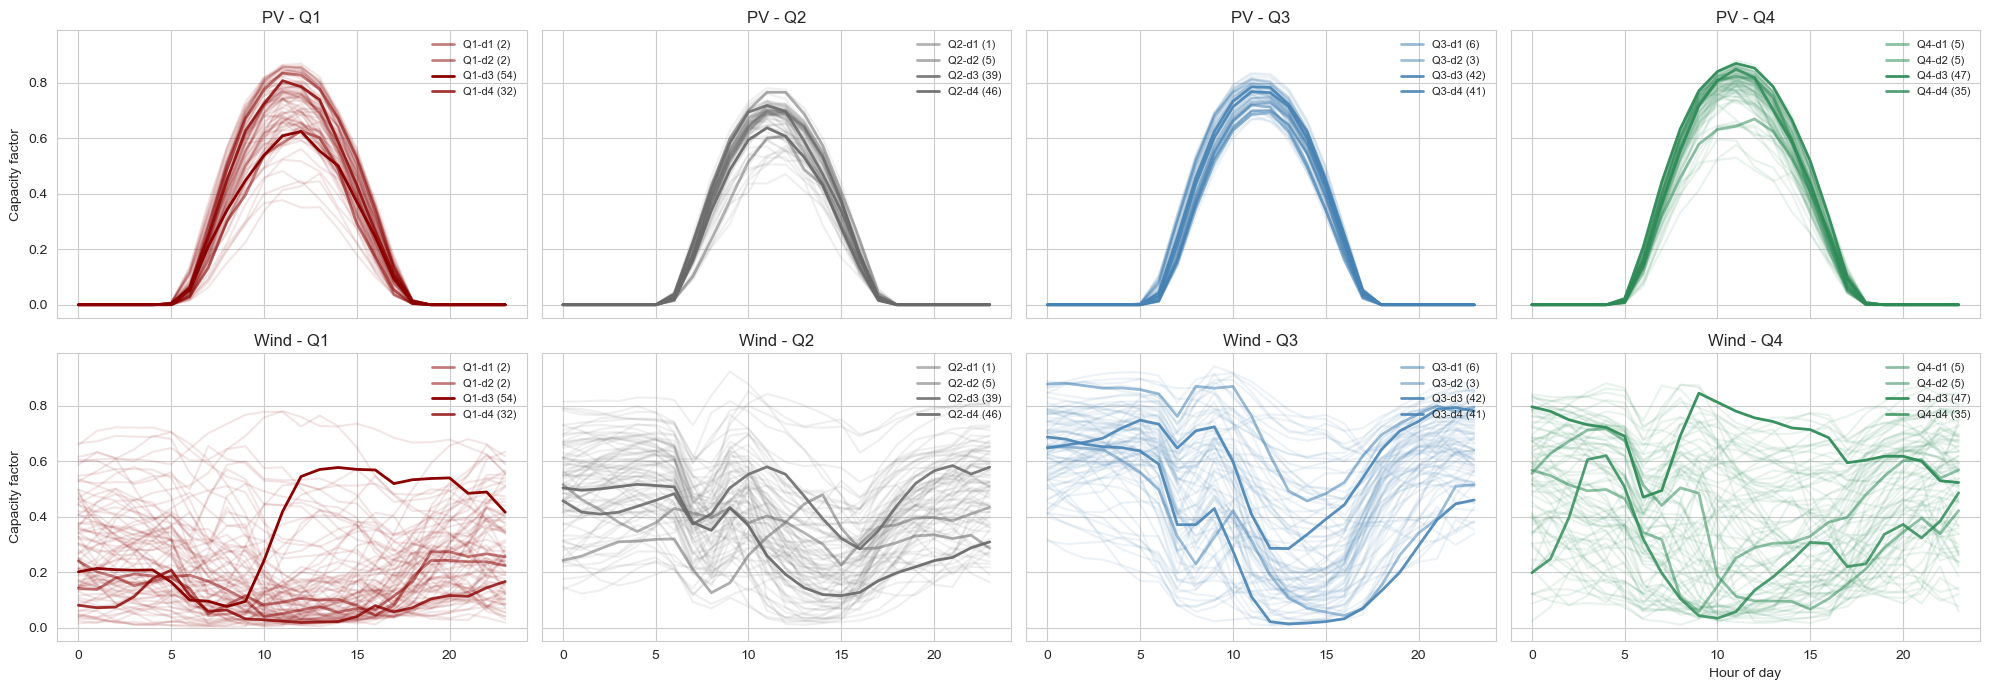

In [14]:
# Checking the representative days

# === SETTINGS ===
season_colors = {
    'Q1': 'darkred',
    'Q2': 'dimgrey',
    'Q3': 'steelblue',
    'Q4': 'seagreen'}

# Representative days per country
country = ['Angola']
plot_vre_repdays(input_file=input_file, vre_profile=VREProfile, pHours=pHours,
          season_colors=season_colors, countries=country, min_alpha=0.5, max_alpha=1, path=None)